In [2]:
from google.colab import drive
drive.mount('/content/drive')


data_dir = "/content/drive/MyDrive/FYP/ser-selective-enhancement/data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
def concordance_correlation_coefficient(y_true, y_pred):
    x_mean = torch.mean(y_true)
    y_mean = torch.mean(y_pred)
    cov = torch.mean((y_true - x_mean) * (y_pred - y_mean))
    x_var = torch.var(y_true)
    y_var = torch.var(y_pred)
    return (2 * cov) / (x_var + y_var + (x_mean - y_mean)**2 + 1e-8)

class CCCLoss(nn.Module):
    def forward(self, pred, target):
        ccc = concordance_correlation_coefficient(target, pred)
        return 1 - ccc  # we want to maximize CCC

In [5]:
class SERProbeModel(nn.Module):
    def __init__(self):
        super(SERProbeModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 25, 128),  # adjust to match input length
            nn.ReLU(),
            nn.Linear(128, 3)  # Arousal, Valence, Dominance
        )

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [6]:
def load_data(feature_dir, labels_df, lld_index):
    X, Y = [], []

    for file in os.listdir(feature_dir):
        if not file.endswith(".csv"):
            continue

        # Convert to .wav for label matching
        base_name = file.replace('.csv', '')
        base_name = re.sub(r'_\d+db', '', base_name).replace('', '')
        wav_file = base_name + '.wav'
        print(f"🔍 Processing file: {file} → matches label: {wav_file}")

        if wav_file not in labels_df['filename'].values:
            print(f"⚠️ Label not found for: {wav_file}")
            continue

        try:
            df = pd.read_csv(os.path.join(feature_dir, file))
        except Exception as e:
            print(f"⚠️ Could not load {file}: {e}")
            continue

        if df.shape[1] <= lld_index:
            print(f"⚠️ File {file} doesn't have LLD index {lld_index}")
            continue

        series = df.iloc[:, lld_index].values[:100]
        if len(series) < 100:
            series = np.pad(series, (0, 100 - len(series)), mode='constant')

        X.append(series)

        label_row = labels_df[labels_df['filename'] == wav_file]
        if label_row.empty:
            print(f"⚠️ No label row found for {wav_file}")
            continue

        Y.append(label_row[['arousal', 'valence', 'dominance']].values[0])

    if not X or not Y:
        print("❌ No valid data loaded.")
        return None, None

    print(f"✅ Loaded {len(X)} samples.")
    return np.array(X), np.array(Y)


In [ ]:
X, Y = load_data(feature_dir, labels_df, 0)
print("✅ Loaded shapes:", X.shape, Y.shape)


Streaming output truncated to the last 5000 lines.
🔍 Processing file: 1017_IWL_HAP_XX_10db.csv → matches label: 1017_IWL_HAP_XX.wav
🔍 Processing file: 1036_IWL_NEU_XX_10db.csv → matches label: 1036_IWL_NEU_XX.wav
🔍 Processing file: 1017_ITS_SAD_XX_10db.csv → matches label: 1017_ITS_SAD_XX.wav
🔍 Processing file: 1017_TSI_HAP_XX_10db.csv → matches label: 1017_TSI_HAP_XX.wav
🔍 Processing file: 1039_IOM_ANG_XX_10db.csv → matches label: 1039_IOM_ANG_XX.wav
🔍 Processing file: 1017_ITS_HAP_XX_10db.csv → matches label: 1017_ITS_HAP_XX.wav
🔍 Processing file: 1017_IEO_FEA_HI_10db.csv → matches label: 1017_IEO_FEA_HI.wav
🔍 Processing file: 1009_DFA_SAD_XX_10db.csv → matches label: 1009_DFA_SAD_XX.wav
🔍 Processing file: 1009_IEO_HAP_HI_10db.csv → matches label: 1009_IEO_HAP_HI.wav
🔍 Processing file: 1017_MTI_FEA_XX_10db.csv → matches label: 1017_MTI_FEA_XX.wav
🔍 Processing file: 1017_IEO_HAP_MD_10db.csv → matches label: 1017_IEO_HAP_MD.wav
🔍 Processing file: 1017_IEO_HAP_LO_10db.csv → matches labe

In [7]:
def train_probe_model(X, Y, epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SERProbeModel().to(device)
    criterion = CCCLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
        targets = torch.tensor(Y_train, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_inputs = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
        val_targets = torch.tensor(Y_val, dtype=torch.float32).to(device)
        preds = model(val_inputs)
        cccs = [concordance_correlation_coefficient(preds[:, i], val_targets[:, i]).item() for i in range(3)]
    return cccs


In [ ]:
import pandas as pd
import os

labels = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')
feature_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced'
output_path = '/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_selectively_enhanced.csv'

# Initialize results file with headers if it doesn't exist
if not os.path.exists(output_path):
    pd.DataFrame(columns=['LLD_Index', 'Arousal', 'Valence', 'Dominance']).to_csv(output_path, index=False)

for lld_idx in range(65):
    print(f"\nEvaluating LLD {lld_idx}")
    X, Y = load_data(feature_dir, labels, lld_idx)

    if X is None or len(X) == 0:
        print(f"Skipping LLD {lld_idx} (no valid data)")
        continue

    try:
        cccs = train_probe_model(X, Y)
        row = {
            'LLD_Index': lld_idx,
            'Arousal': cccs[0],
            'Valence': cccs[1],
            'Dominance': cccs[2]
        }

        # Append result to file
        pd.DataFrame([row]).to_csv(output_path, mode='a', header=False, index=False)
        print(f"✅ LLD {lld_idx} result saved.")

    except Exception as e:
        print(f"❌ Error evaluating LLD {lld_idx}: {e}")

print(f"\n🎉 Evaluation complete! All results saved to: {output_path}")


Streaming output truncated to the last 5000 lines.
🔍 Processing file: 1017_ITS_SAD_XX_10db.csv → matches label: 1017_ITS_SAD_XX.wav
🔍 Processing file: 1017_TSI_HAP_XX_10db.csv → matches label: 1017_TSI_HAP_XX.wav
🔍 Processing file: 1039_IOM_ANG_XX_10db.csv → matches label: 1039_IOM_ANG_XX.wav
🔍 Processing file: 1017_ITS_HAP_XX_10db.csv → matches label: 1017_ITS_HAP_XX.wav
🔍 Processing file: 1017_IEO_FEA_HI_10db.csv → matches label: 1017_IEO_FEA_HI.wav
🔍 Processing file: 1009_DFA_SAD_XX_10db.csv → matches label: 1009_DFA_SAD_XX.wav
🔍 Processing file: 1009_IEO_HAP_HI_10db.csv → matches label: 1009_IEO_HAP_HI.wav
🔍 Processing file: 1017_MTI_FEA_XX_10db.csv → matches label: 1017_MTI_FEA_XX.wav
🔍 Processing file: 1017_IEO_HAP_MD_10db.csv → matches label: 1017_IEO_HAP_MD.wav
🔍 Processing file: 1017_IEO_HAP_LO_10db.csv → matches label: 1017_IEO_HAP_LO.wav
🔍 Processing file: 1038_DFA_HAP_XX_10db.csv → matches label: 1038_DFA_HAP_XX.wav
🔍 Processing file: 1009_IEO_DIS_LO_10db.csv → matches labe

In [ ]:
noisy_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_noisy_10db.csv')
enhanced_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_selectively_enhanced.csv')

comparison = pd.merge(noisy_df, enhanced_df, on='LLD_Index', suffixes=('_Noisy', '_Enhanced'))

# Calculate improvement
for emo in ['Arousal', 'Valence', 'Dominance']:
    comparison[f'{emo}_Delta'] = comparison[f'{emo}_Enhanced'] - comparison[f'{emo}_Noisy']

# Save the comparison
comparison.to_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_comparison.csv', index=False)

print("✅ Comparison file saved: probe_ccc_comparison.csv")


✅ Comparison file saved: probe_ccc_comparison.csv


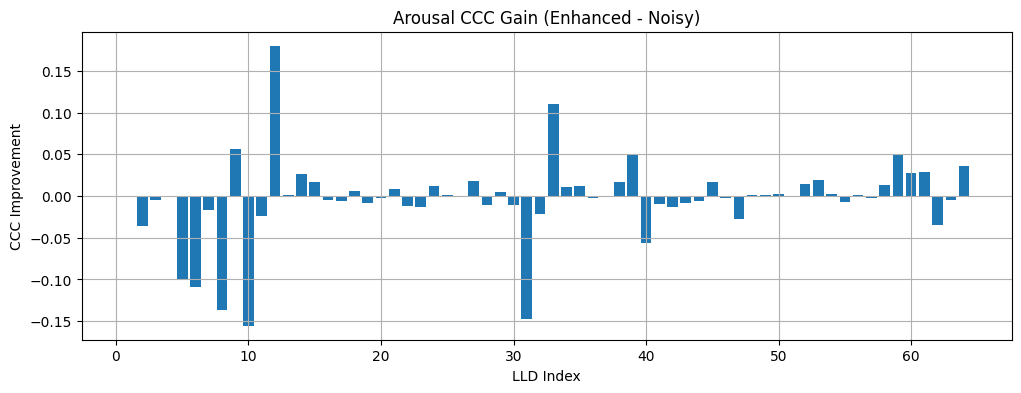

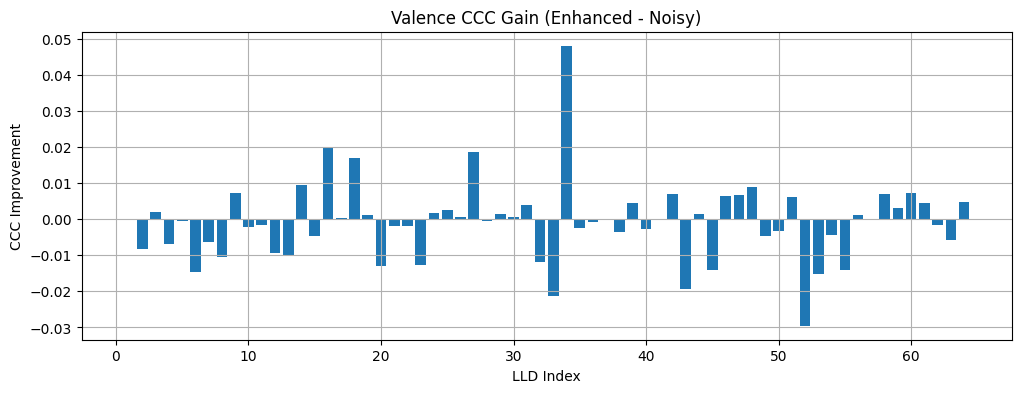

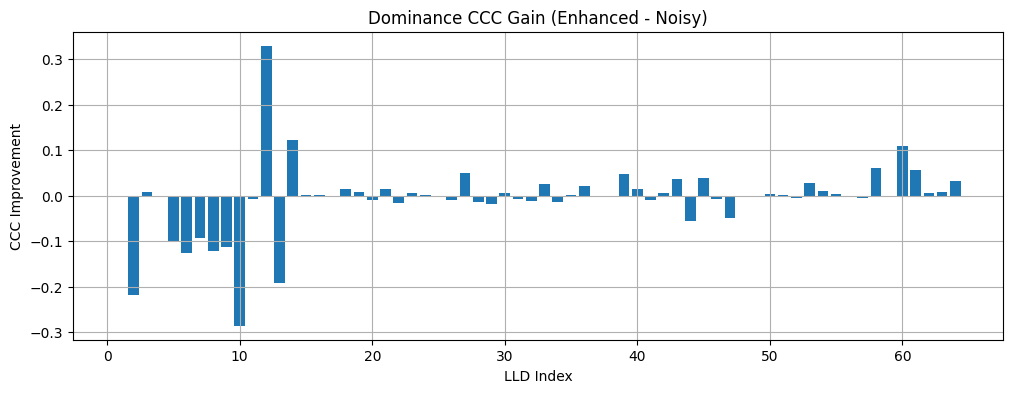

In [ ]:
import matplotlib.pyplot as plt

for emo in ['Arousal', 'Valence', 'Dominance']:
    plt.figure(figsize=(12, 4))
    plt.bar(comparison['LLD_Index'], comparison[f'{emo}_Delta'])
    plt.title(f'{emo} CCC Gain (Enhanced - Noisy)')
    plt.xlabel("LLD Index")
    plt.ylabel("CCC Improvement")
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load files
noisy_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_noisy_10db.csv')
enhanced_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_selectively_enhanced.csv')

# Merge on LLD_Index
df = pd.merge(noisy_df, enhanced_df, on='LLD_Index', suffixes=('_Noisy', '_Enhanced'))

# Calculate percentage gain (avoid division by zero)
for emo in ['Arousal', 'Valence', 'Dominance']:
    noisy = df[f'{emo}_Noisy']
    enhanced = df[f'{emo}_Enhanced']
    relative_gain = ((enhanced - noisy) / (np.abs(noisy) + 1e-6)) * 100
    df[f'{emo}_Gain_%'] = relative_gain

# Calculate average gain
avg_arousal_gain = df['Arousal_Gain_%'].mean()
avg_valence_gain = df['Valence_Gain_%'].mean()
avg_dominance_gain = df['Dominance_Gain_%'].mean()

print(f"📈 Arousal CCC Gain:   {avg_arousal_gain:.2f}%")
print(f"📈 Valence CCC Gain:   {avg_valence_gain:.2f}%")
print(f"📈 Dominance CCC Gain: {avg_dominance_gain:.2f}%")


📈 Arousal CCC Gain:   85.91%
📈 Valence CCC Gain:   285.21%
📈 Dominance CCC Gain: 60.39%


In [ ]:
import os
print("📂 Files in selectively_enhanced:")
print(os.listdir('/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced')[:5])

print("📄 Labels.csv sample:")
labels_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')
print(labels_df.head())


📂 Files in selectively_enhanced:
['1082_TSI_ANG_XX_10db.csv', '1086_IEO_FEA_MD_10db.csv', '1081_TIE_FEA_XX_10db.csv', '1070_IWW_SAD_XX_10db.csv', '1086_IEO_DIS_LO_10db.csv']
📄 Labels.csv sample:
              filename  emotion  arousal  valence  dominance
0  1003_IEO_SAD_LO.wav      sad     0.25    -0.65       0.40
1  1002_MTI_ANG_XX.wav    angry     0.85    -0.70       0.75
2  1002_TAI_FEA_XX.wav  fearful     0.90    -0.80       0.30
3  1002_MTI_HAP_XX.wav    happy     0.80     0.90       0.65
4  1002_TIE_SAD_XX.wav      sad     0.25    -0.65       0.40


In [ ]:
file = '1011_TAI_DIS_XX_10db.csv'
base_name = file.replace('.csv', '')
base_name = re.sub(r'_\d+db', '', base_name).replace('', '')
wav_file = base_name + '.wav'

labels_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')
print("🔗 Should match label:", wav_file)
print(wav_file in labels_df['filename'].values)  # should print True ✅


🔗 Should match label: 1011_TAI_DIS_XX.wav
True


In [ ]:
import pandas as pd
import os

labels = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/data/labels.csv')
feature_dir = '/content/drive/MyDrive/FYP/ser-selective-enhancement/features/selectively_enhanced_5db'
output_path = '/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_selectively_enhanced_5db.csv'

# Initialize results file with headers if it doesn't exist
if not os.path.exists(output_path):
    pd.DataFrame(columns=['LLD_Index', 'Arousal', 'Valence', 'Dominance']).to_csv(output_path, index=False)

for lld_idx in range(65):
    print(f"\nEvaluating LLD {lld_idx}")
    X, Y = load_data(feature_dir, labels, lld_idx)

    if X is None or len(X) == 0:
        print(f"Skipping LLD {lld_idx} (no valid data)")
        continue

    try:
        cccs = train_probe_model(X, Y)
        row = {
            'LLD_Index': lld_idx,
            'Arousal': cccs[0],
            'Valence': cccs[1],
            'Dominance': cccs[2]
        }

        # Append result to file
        pd.DataFrame([row]).to_csv(output_path, mode='a', header=False, index=False)
        print(f"✅ LLD {lld_idx} result saved.")

    except Exception as e:
        print(f"❌ Error evaluating LLD {lld_idx}: {e}")

print(f"\n🎉 Evaluation complete! All results saved to: {output_path}")


Streaming output truncated to the last 5000 lines.
🔍 Processing file: 1033_TIE_SAD_XX_5db.csv → matches label: 1033_TIE_SAD_XX.wav
🔍 Processing file: 1052_ITS_SAD_XX_5db.csv → matches label: 1052_ITS_SAD_XX.wav
🔍 Processing file: 1052_DFA_FEA_XX_5db.csv → matches label: 1052_DFA_FEA_XX.wav
🔍 Processing file: 1052_IWW_HAP_XX_5db.csv → matches label: 1052_IWW_HAP_XX.wav
🔍 Processing file: 1051_IWW_FEA_XX_5db.csv → matches label: 1051_IWW_FEA_XX.wav
🔍 Processing file: 1052_IWW_ANG_XX_5db.csv → matches label: 1052_IWW_ANG_XX.wav
🔍 Processing file: 1052_IEO_FEA_LO_5db.csv → matches label: 1052_IEO_FEA_LO.wav
🔍 Processing file: 1052_IEO_ANG_LO_5db.csv → matches label: 1052_IEO_ANG_LO.wav
🔍 Processing file: 1052_DFA_ANG_XX_5db.csv → matches label: 1052_DFA_ANG_XX.wav
🔍 Processing file: 1052_IWL_NEU_XX_5db.csv → matches label: 1052_IWL_NEU_XX.wav
🔍 Processing file: 1051_WSI_DIS_XX_5db.csv → matches label: 1051_WSI_DIS_XX.wav
🔍 Processing file: 1052_ITH_DIS_XX_5db.csv → matches label: 1052_ITH_

In [ ]:
noisy_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_noisy_10db.csv')
enhanced_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_selectively_enhanced.csv')

comparison = pd.merge(noisy_df, enhanced_df, on='LLD_Index', suffixes=('_Noisy', '_Enhanced'))

# Calculate improvement
for emo in ['Arousal', 'Valence', 'Dominance']:
    comparison[f'{emo}_Delta'] = comparison[f'{emo}_Enhanced'] - comparison[f'{emo}_Noisy']

# Save the comparison
comparison.to_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_comparison_5db.csv', index=False)

print("✅ Comparison file saved: probe_ccc_comparison_5db.csv")


✅ Comparison file saved: probe_ccc_comparison_5db.csv


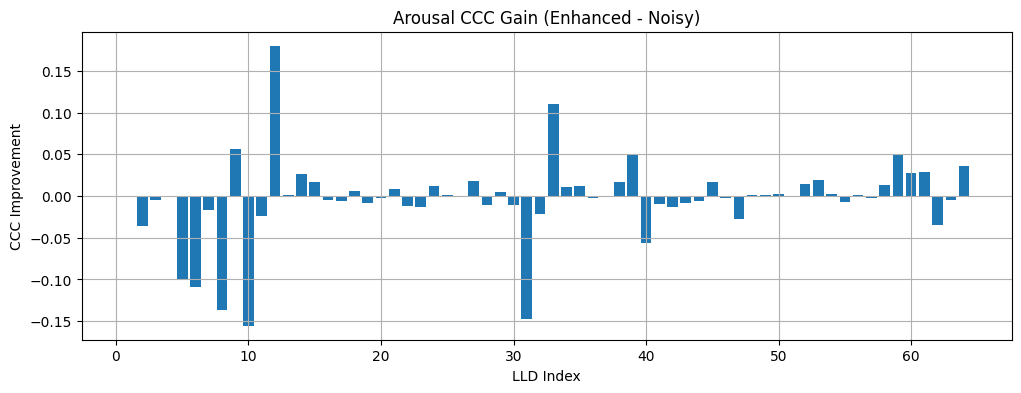

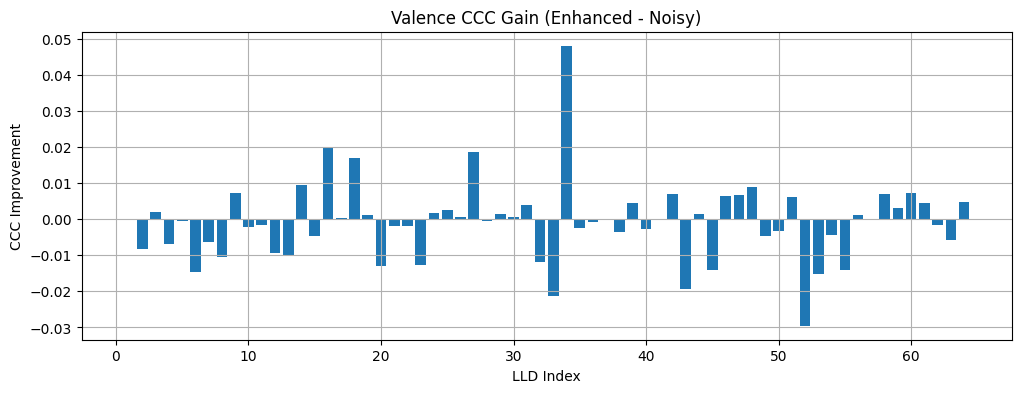

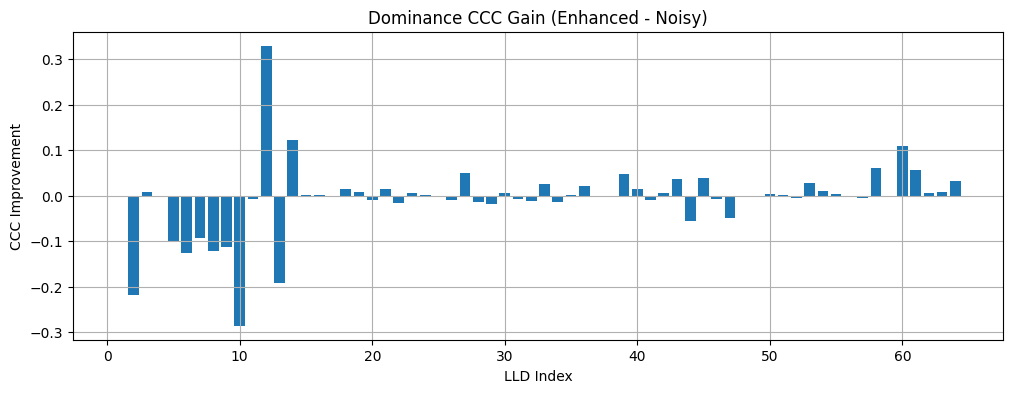

In [ ]:
import matplotlib.pyplot as plt

for emo in ['Arousal', 'Valence', 'Dominance']:
    plt.figure(figsize=(12, 4))
    plt.bar(comparison['LLD_Index'], comparison[f'{emo}_Delta'])
    plt.title(f'{emo} CCC Gain (Enhanced - Noisy)')
    plt.xlabel("LLD Index")
    plt.ylabel("CCC Improvement")
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Load files
noisy_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_noisy_5db.csv')
enhanced_df = pd.read_csv('/content/drive/MyDrive/FYP/ser-selective-enhancement/outputs/probe_ccc_results_selectively_enhanced_5db.csv')

# Merge on LLD_Index
df = pd.merge(noisy_df, enhanced_df, on='LLD_Index', suffixes=('_Noisy', '_Enhanced'))

# Calculate percentage gain (avoid division by zero)
for emo in ['Arousal', 'Valence', 'Dominance']:
    noisy = df[f'{emo}_Noisy']
    enhanced = df[f'{emo}_Enhanced']
    relative_gain = ((enhanced - noisy) / (np.abs(noisy) + 1e-6)) * 100
    df[f'{emo}_Gain_%'] = relative_gain

# Calculate average gain
avg_arousal_gain = df['Arousal_Gain_%'].mean()
avg_valence_gain = df['Valence_Gain_%'].mean()
avg_dominance_gain = df['Dominance_Gain_%'].mean()

print(f"📈 Arousal CCC Gain:   {avg_arousal_gain:.2f}%")
print(f"📈 Valence CCC Gain:   {avg_valence_gain:.2f}%")
print(f"📈 Dominance CCC Gain: {avg_dominance_gain:.2f}%")


📈 Arousal CCC Gain:   30.38%
📈 Valence CCC Gain:   78.83%
📈 Dominance CCC Gain: 61.34%


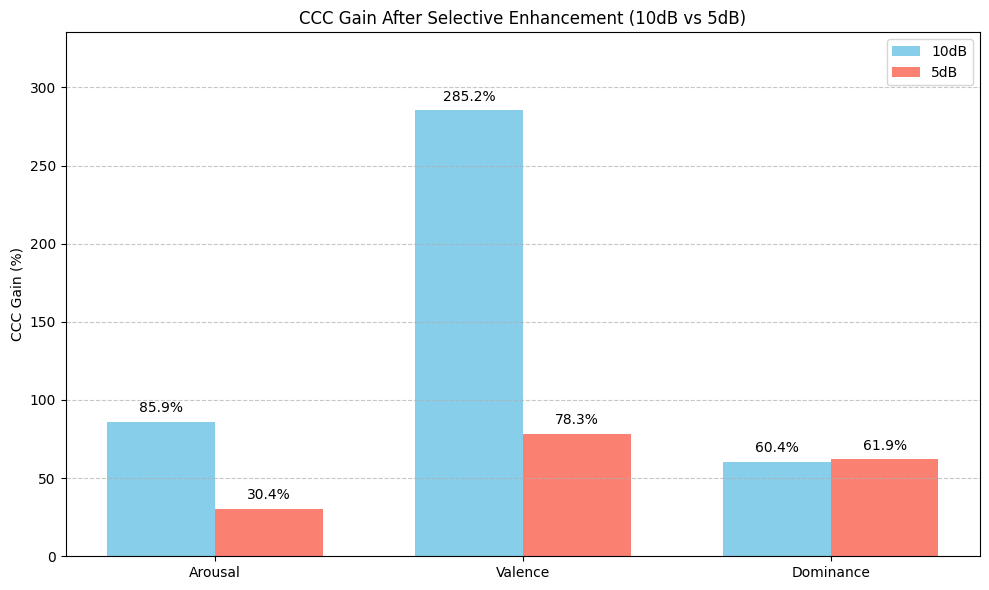

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and values
emotions = ['Arousal', 'Valence', 'Dominance']
gain_10db = [85.91, 285.21, 60.39]
gain_5db = [30.38, 78.35, 61.94]

# X-axis locations
x = np.arange(len(emotions))
width = 0.35  # width of the bars

# Plotting
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, gain_10db, width, label='10dB', color='skyblue')
bars2 = plt.bar(x + width/2, gain_5db, width, label='5dB', color='salmon')

# Labels and title
plt.ylabel('CCC Gain (%)')
plt.title('CCC Gain After Selective Enhancement (10dB vs 5dB)')
plt.xticks(x, emotions)
plt.ylim(0, max(gain_10db + gain_5db) + 50)
plt.legend()

# Annotate values on top
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),  # offset
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
